In [17]:
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import plot

import importlib
importlib.reload(plot)

import numpy as np

## What are autoencoders

* Multilayer artificial neural networks
* Uses `representation learning`
* Tries to mimic input at the output
<img src="http://fastforwardlabs.github.io/blog-images/miriam/miriams-figure.png">

### * Map high-dimensional data another space
### * Compression
### * Learn abstract features in an unsupervised way (labeled data is expensive)
### * Denoising and hole-filling
<img src="hole-fill.png">

## Basic autoencoder example


In [14]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Build model

In [15]:
from keras import regularizers

encoding_dim = 32
input_img = Input(shape=(28 * 28,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-50))(input_img)
# encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(28 * 28, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# get encoder and decoder separately
encoded_input = Input(shape=(encoding_dim, ))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoder = Model(input_img, encoded)


### Train model

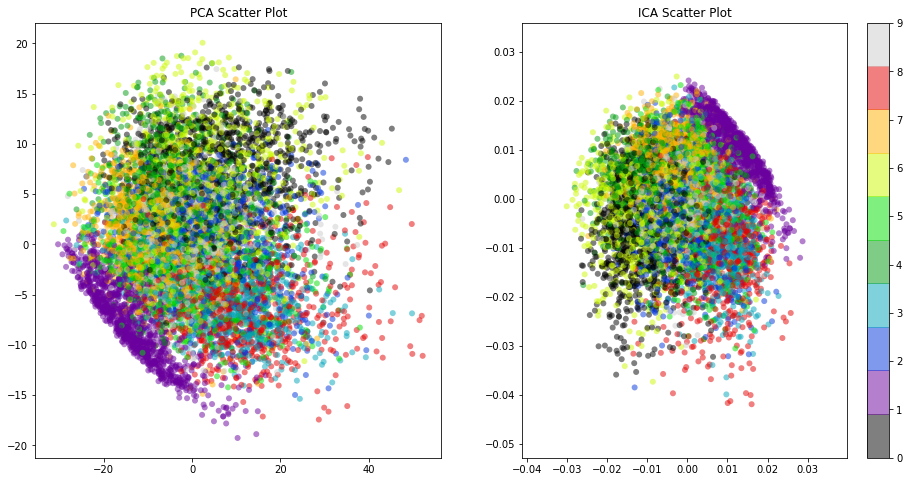

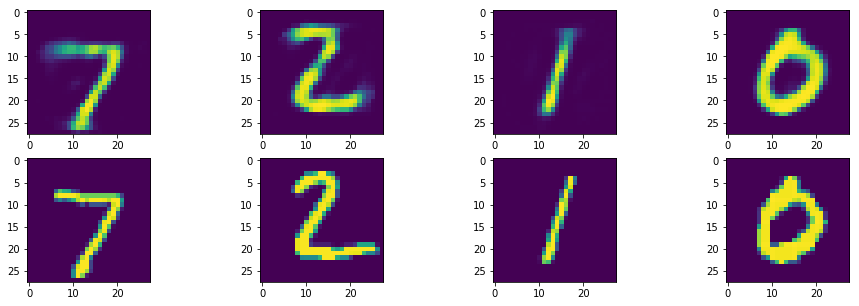

60000/60000 [==============================] - 13s 215us/step - loss: 0.1026 - val_loss: 0.1008


In [54]:
importlib.reload(plot)
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[plot.Plot(x_test, y_test, encoder, decoder)])

In [ ]:
number_of_images = 10
encoded_imgs = encoder.predict(x_test[:number_of_images])
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(number_of_images):
    # display original
    ax = plt.subplot(2, number_of_images, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number_of_images, i + 1 + number_of_images)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Variational Autoencoders

- Probabalistic approach to autoencoders
- learns a Latent Variable Model Instead of learning an arbitrary representation
- Generally no parameter tuning required

<img src="https://cdn-images-1.medium.com/max/2000/1*22cSCfmktNIwH5m__u2ffA.png">

- Vanilla autoencoder is deterministic
- Variational Autoencoder is stochastic. It learns a lattent variable $z$ from inputs $x$

> Probabilistic encoder approximating the true posterior $q(z|x)$.
***
> Generative decoder samples posterior $\hat{q}(z|x)$ aproximation, which does not rely on any particular input x.

- Learning conditional distributions is facilitated by forcing a prior.
$$  z\sim N(0,I). $$
<img src="http://fastforwardlabs.github.io/blog-images/miriam/imgs_code/vae.4.png">


### A VAE has three basic parts:

- 1) An encoder that that learns the parameters (mean and variance) of the underlying latent distribution;
- 2) A means of sampling from that distribution;
- 3) A decoder that can turn the sample back into an image.

### 1) Encoder:

In [ ]:
img_size = (28 * 28, )
batch_size = 256
hidden_size = 128
latent_size = 16

inputs = Input(shape=img_size, name='encoder_input')
x = Dense(hidden_size, activation='relu')(inputs)
z_mean = Dense(latent_size, name='z_mean')(x)
z_log_var = Dense(latent_size, name='z_log_var')(x)

### 2) Sampling function

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    latent_size = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch_size, latent_size))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_size,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

### 3) Decoder

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


In [ ]:
vae = Model(x, decoded)

In [ ]:
idx = np.arange(5000)
np.random.shuffle(idx)

vae.fit(x=x_train[idx, :].reshape((-1, 28, 28, 1)), y=None,
        shuffle=True,
        epochs=7,
        batch_size=256,
        validation_data=(x_test[idx[:1000]].reshape((-1, 28, 28, 1)), None))

In [ ]:
X_valid_noTest = x_test.reshape(-1,28,28,1)
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_test, cmap='brg')
plt.colorbar()
plt.show()
